# Rozdział 17. Przetwarzanie sygnałów

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import matplotlib as mpl

In [5]:
from scipy import fftpack

In [6]:
# Można również skorzystać z
# from numpy import fft as fftpack

In [7]:
from scipy import signal

In [8]:
import scipy.io.wavfile

In [9]:
from scipy import io

## Analiza spektralna sygnału

In [10]:
def signal_samples(t):
    """ Symulacja próbek sygnału """
    return (2 * np.sin(1 * 2 * np.pi * t) +
            3 * np.sin(22 * 2 * np.pi * t) +
            2 * np.random.randn(*np.shape(t)))

In [11]:
np.random.seed(0)

In [12]:
B = 30.0

In [13]:
f_s = 2 * B
f_s

60.0

In [14]:
delta_f = 0.01

In [15]:
N = int(f_s / delta_f)
N

6000

In [16]:
T = N / f_s
T

100.0

In [17]:
f_s / N

0.01

In [18]:
t = np.linspace(0, T, N)

In [19]:
f_t = signal_samples(t)

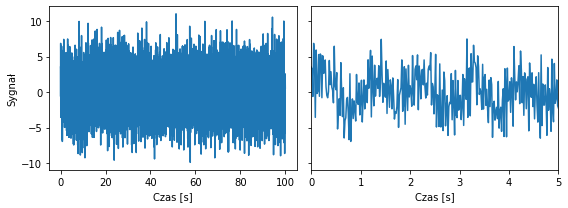

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].plot(t, f_t)
axes[0].set_xlabel("Czas [s]")
axes[0].set_ylabel("Sygnał")
axes[1].plot(t, f_t)
axes[1].set_xlim(0, 5)
axes[1].set_xlabel("Czas [s]")
fig.tight_layout()
fig.savefig("ch17-simulated-signal.pdf")
fig.savefig("ch17-simulated-signal.png")

In [21]:
F = fftpack.fft(f_t)
F

array([-185.36700984  -0.j        ,   64.31465411 +84.35131087j,
       -194.62006295 +39.42459117j, ...,  -28.445381  -145.77964819j,
       -194.62006295 -39.42459117j,   64.31465411 -84.35131087j])

In [22]:
f = fftpack.fftfreq(N, 1/f_s)
f

array([ 0.  ,  0.01,  0.02, ..., -0.03, -0.02, -0.01])

In [23]:
mask = np.where(f >= 0)

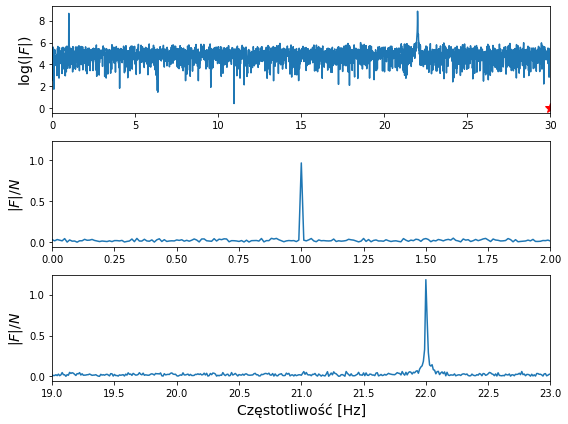

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].plot(f[mask], np.log(abs(F[mask])), label="Cześć rzeczywista")
axes[0].plot(B, 0, 'r*', markersize=10)
axes[0].set_xlim(0, 30)
axes[0].set_ylabel("$\log(|F|)$", fontsize=14)

axes[1].plot(f[mask], abs(F[mask])/N, label="Cześć rzeczywista")
axes[1].set_xlim(0, 2)
axes[1].set_ylabel("$|F|/N$", fontsize=14)

axes[2].plot(f[mask], abs(F[mask])/N, label="Cześć rzeczywista")
axes[2].set_xlim(19, 23)
axes[2].set_xlabel("Częstotliwość [Hz]", fontsize=14)
axes[2].set_ylabel("$|F|/N$", fontsize=14)

fig.tight_layout()
fig.savefig("ch17-simulated-signal-spectrum.pdf")
fig.savefig("ch17-simulated-signal-spectrum.png")

## Prosty przykład filtrowania

In [25]:
F_filtered = F * (abs(f) < 2)

In [26]:
f_t_filtered = fftpack.ifft(F_filtered)

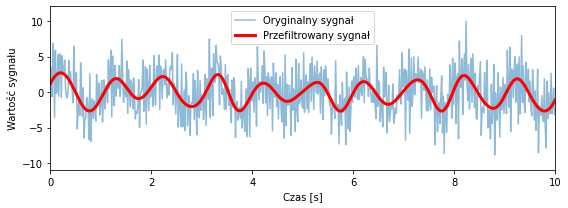

In [27]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, f_t, label='Oryginalny sygnał', alpha=0.5)
ax.plot(t, f_t_filtered.real, color="red", lw=3, label='Przefiltrowany sygnał')
ax.set_xlim(0, 10)
ax.set_xlabel("Czas [s]")
ax.set_ylabel("Wartość sygnału")
ax.legend()
fig.tight_layout()
fig.savefig("ch17-inverse-fft.pdf")
fig.savefig("ch17-inverse-fft.png")

## Okna czasowe

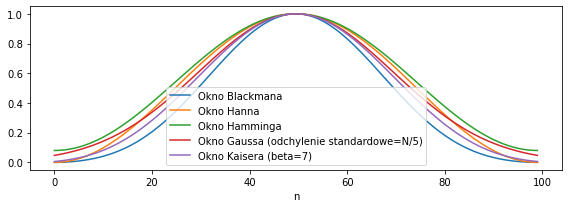

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
N = 100
ax.plot(signal.blackman(N), label="Okno Blackmana")
ax.plot(signal.hann(N), label="Okno Hanna")
ax.plot(signal.hamming(N), label="Okno Hamminga")
ax.plot(signal.gaussian(N, N/5), label="Okno Gaussa (odchylenie standardowe=N/5)")
ax.plot(signal.kaiser(N, 7), label="Okno Kaisera (beta=7)")
ax.set_xlabel("n")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-window-functions.pdf")

In [29]:
df = pd.read_csv('temperatury_zewnetrzne_2014.tsv', delimiter="\t", names=["Data", "Temperatura"])

In [30]:
df.Data = pd.to_datetime(df.Data.values, unit="s").tz_localize('UTC').tz_convert('Europe/Stockholm')

In [31]:
df = df.set_index("Data")

In [32]:
df = df.resample("1H").ffill()

In [33]:
df = df[(df.index >= "2014-04-01")*(df.index < "2014-06-01")].dropna()

In [34]:
time = df.index.astype('int')/1e9

In [35]:
temperature = df.Temperatura.values

In [36]:
temperature_detrended = signal.detrend(temperature)

In [37]:
window = signal.blackman(len(temperature_detrended))

In [38]:
temperature_windowed = temperature * window

In [39]:
data_fft = fftpack.fft(temperature)
data_fft_detrended = fftpack.fft(temperature_detrended)
data_fft_windowed = fftpack.fft(temperature_windowed)


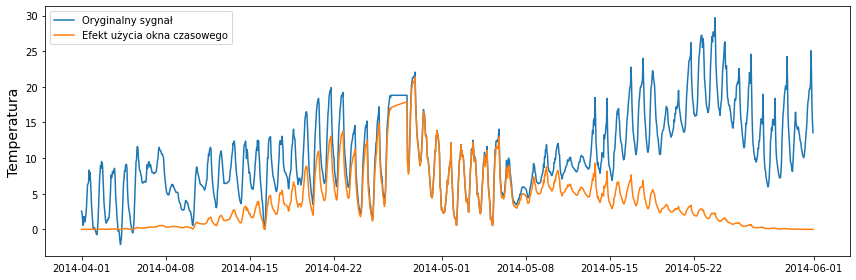

In [40]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.plotting.register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, temperature, label="Oryginalny sygnał")
#ax.plot(df.index, temperature_detrended, label="detrended")
ax.plot(df.index, temperature_windowed, label="Efekt użycia okna czasowego")
ax.set_ylabel("Temperatura", fontsize=14)
ax.legend(loc=0)

fig.tight_layout()
fig.savefig("ch17-temperature-signal.pdf")

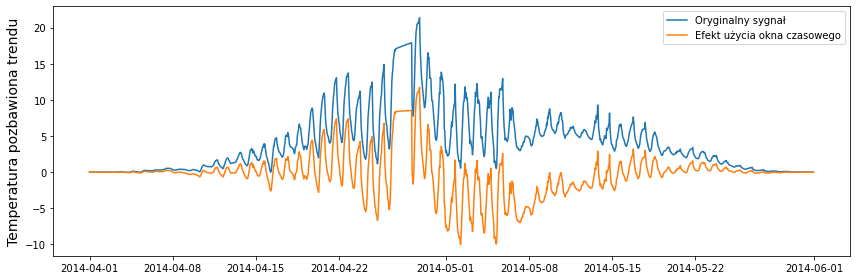

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.index, temperature_windowed, label="Oryginalny sygnał")
ax.plot(df.index, temperature_detrended * window, label="Efekt użycia okna czasowego")
ax.set_ylabel("Temperatura pozbawiona trendu", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
#fig.savefig("ch17-temperature-signal.pdf")

In [42]:
f = fftpack.fftfreq(len(temperature_windowed), time[1]-time[0])

In [43]:
mask = f > 0

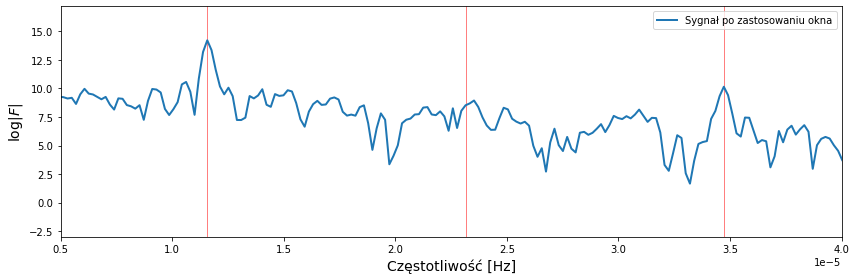

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlim(0.000001, 0.000025)
#ax.set_xlim(0.000005, 0.000018)
ax.set_xlim(0.000005, 0.00004)

ax.axvline(1./86400, color='r', lw=0.5)
ax.axvline(2./86400, color='r', lw=0.5)
ax.axvline(3./86400, color='r', lw=0.5)
#ax.plot(f[mask], np.log(abs(data_fft[mask])**2), lw=2, label="Oryginalny sygnał")
#ax.plot(f[mask], np.log(abs(data_fft_detrended[mask])**2), lw=2, label="Sygnał po usunięciu trendu")
ax.plot(f[mask], np.log(abs(data_fft_windowed[mask])**2), lw=2, label="Sygnał po zastosowaniu okna")
ax.set_ylabel("$\log|F|$", fontsize=14)
ax.set_xlabel("Częstotliwość [Hz]", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-spectrum.pdf")

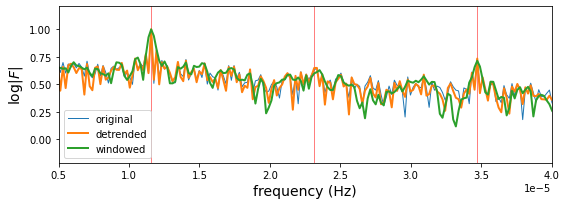

In [45]:
fig, ax = plt.subplots(figsize=(8, 3))
#ax.set_xlim(0.000001, 0.000025)
#ax.set_xlim(0.000005, 0.000018)
ax.set_xlim(0.000005, 0.00004)

ax.axvline(1./86400, color='r', lw=0.5)
ax.axvline(2./86400, color='r', lw=0.5)
ax.axvline(3./86400, color='r', lw=0.5)

y =  np.log(abs(data_fft[mask])**2)
ax.plot(f[mask], y / y[10:].max(), lw=1, label="original")

y = np.log(abs(data_fft_detrended[mask])**2)
ax.plot(f[mask], y / y[10:].max(), lw=2, label="detrended")

y = np.log(abs(data_fft_windowed[mask])**2)
ax.plot(f[mask], y / y[10:].max(), lw=2, label="windowed")

ax.set_ylabel("$\log|F|$", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-spectrum.pdf")

## Spektrogram gitary

In [46]:
# https://www.freesound.org/people/guitarguy1985/sounds/52047/

In [47]:
sample_rate, data = io.wavfile.read("gitara.wav")

In [48]:
sample_rate

44100

In [49]:
data.shape

(1181625, 2)

In [50]:
data = data.mean(axis=1)

In [51]:
data.shape[0] / sample_rate

26.79421768707483

In [52]:
N = int(sample_rate/2.0); N # Pół sekundy -> 22 050 próbek

22050

In [53]:
f = fftpack.fftfreq(N, 1.0/sample_rate)

In [54]:
t = np.linspace(0, 0.5, N)

In [55]:
mask = (f > 0) * (f < 1000)

In [56]:
subdata = data[:N]

In [57]:
F = fftpack.fft(subdata)

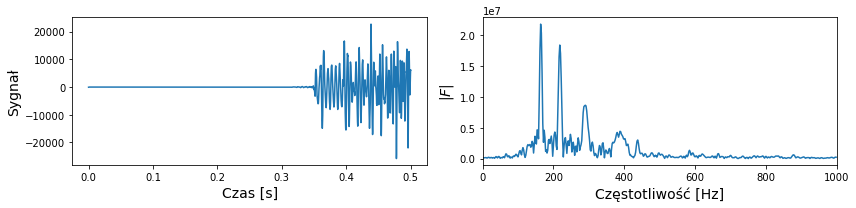

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(t, subdata)
axes[0].set_ylabel("Sygnał", fontsize=14)
axes[0].set_xlabel("Czas [s]", fontsize=14)
axes[1].plot(f[mask], abs(F[mask]))
axes[1].set_xlim(0, 1000)
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Częstotliwość [Hz]", fontsize=14)
fig.tight_layout()
fig.savefig("ch17-guitar-spectrum.pdf")

In [59]:
N_max = int(data.shape[0] / N)

In [60]:
f_values = np.sum(1 * mask)

In [61]:
spect_data = np.zeros((N_max, f_values))

In [62]:
window = signal.blackman(len(subdata))

In [63]:
for n in range(0, N_max):
    subdata = data[(N * n):(N * (n + 1))]
    F = fftpack.fft(subdata * window)
    spect_data[n, :] = np.log(abs(F[mask]))

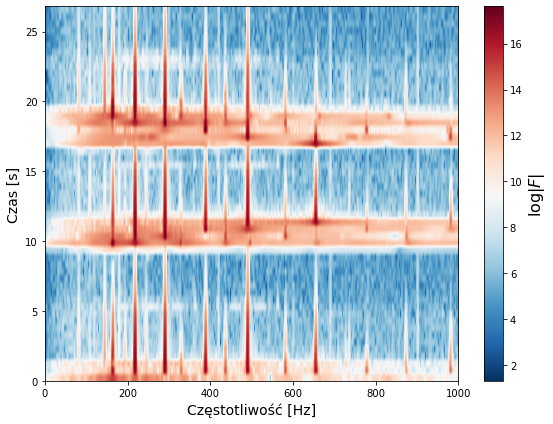

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
p = ax.imshow(spect_data, origin='lower',
              extent=(0, 1000, 0, data.shape[0] / sample_rate),
              aspect='auto',
              cmap=mpl.cm.RdBu_r)
cb = fig.colorbar(p, ax=ax)
cb.set_label("$\log|F|$", fontsize=16)
ax.set_ylabel("Czas [s]", fontsize=14)
ax.set_xlabel("Częstotliwość [Hz]", fontsize=14)
fig.tight_layout()
fig.savefig("ch17-spectrogram.pdf")
fig.savefig("ch17-spectrogram.png")

## Filtrowanie sygnałów

### Filtr konwolucyjny

In [65]:
# Przywracam wartości z porzedniego przykładu
np.random.seed(0)
B = 30.0
f_s = 2 * B
delta_f = 0.01
N = int(f_s / delta_f)
T = N / f_s
t = np.linspace(0, T, N)
f_t = signal_samples(t)
f = fftpack.fftfreq(N, 1/f_s)

In [69]:
H = (abs(f) < 2)

In [70]:
h = fftpack.fftshift(fftpack.ifft(H))

In [71]:
f_t_filtered = fftpack.fftshift(fftpack.ifft(H))

In [72]:
f_t_filtered_conv = signal.convolve(f_t, h, mode='same')

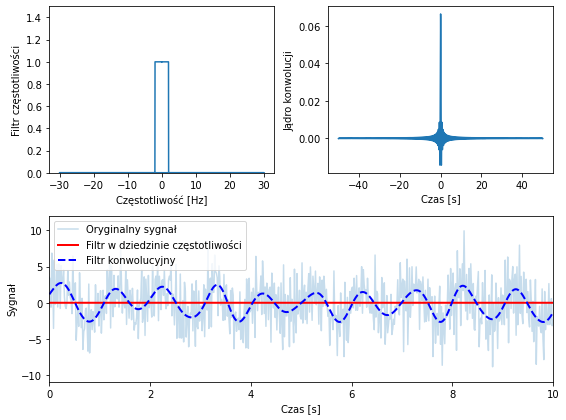

In [73]:
fig = plt.figure(figsize=(8, 6))

ax = plt.subplot2grid((2,2), (0,0))
ax.plot(f, H)
ax.set_xlabel("Częstotliwość [Hz]")
ax.set_ylabel("Filtr częstotliwości")
ax.set_ylim(0, 1.5)

ax = plt.subplot2grid((2,2), (0,1))
ax.plot(t - 50, h.real)
ax.set_xlabel("Czas [s]")
ax.set_ylabel("Jądro konwolucji")

ax = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.plot(t, f_t, label='Oryginalny sygnał', alpha=0.25)
ax.plot(t, f_t_filtered.real, "r", lw=2, label='Filtr w dziedzinie częstotliwości')
ax.plot(t, f_t_filtered_conv.real, 'b--', lw=2, label='Filtr konwolucyjny')
ax.set_xlim(0, 10)
ax.set_xlabel("Czas [s]")
ax.set_ylabel("Sygnał")
ax.legend(loc=2)

fig.tight_layout()
fig.savefig("ch17-convolution-filter.pdf")
fig.savefig("ch17-convolution-filter.png")

### Filtr o skończonej odpowiedzi impulsowej

In [74]:
n = 101

In [75]:
f_s = 1.0 / 3600

In [76]:
nyq = f_s/2

In [77]:
b = signal.firwin(n, cutoff=nyq/12, nyq=nyq, window="hamming")

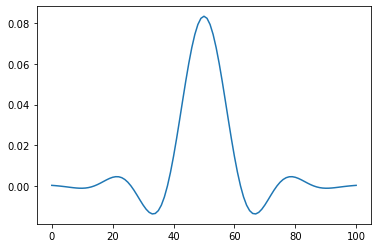

In [78]:
plt.plot(b);

In [79]:
f, h = signal.freqz(b)

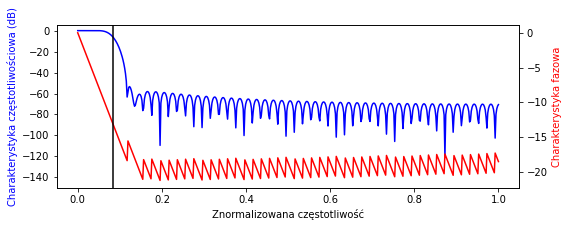

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f), h_ampl, 'b')
ax.set_ylim(-150, 5)
ax.set_ylabel('Charakterystyka częstotliwościowa (dB)', color="b")
ax.set_xlabel(r'Znormalizowana częstotliwość')
ax = ax.twinx()
ax.plot(f/max(f), h_phase, 'r')
ax.set_ylabel('Charakterystyka fazowa', color="r")
ax.axvline(1.0/12, color="black")
fig.tight_layout()
fig.savefig("ch17-filter-frequency-response.pdf")

In [81]:
temperature_filtered = signal.lfilter(b, 1, temperature)

In [82]:
temperature_median_filtered = signal.medfilt(temperature, 25)

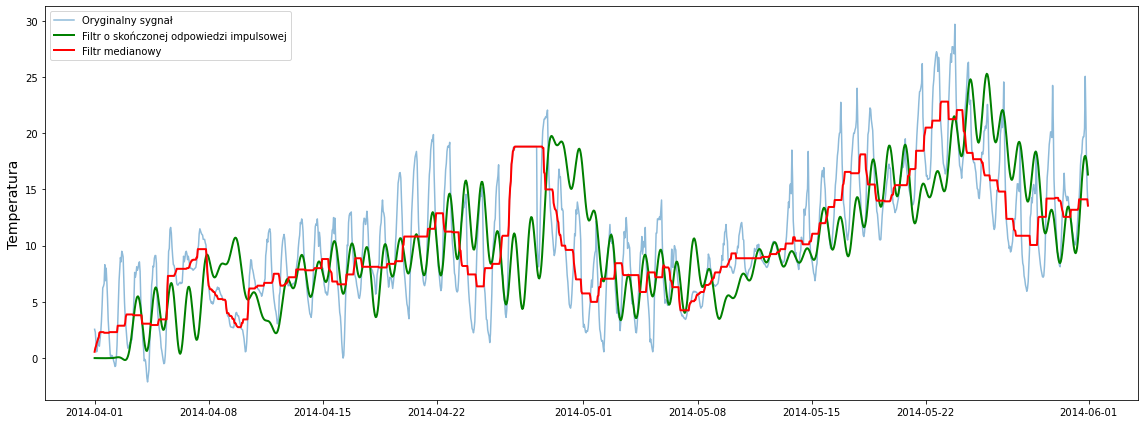

In [83]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df.index, temperature, label="Oryginalny sygnał", alpha=0.5)
ax.plot(df.index, temperature_filtered, color="green", lw=2, label="Filtr o skończonej odpowiedzi impulsowej")
ax.plot(df.index, temperature_median_filtered, color="red", lw=2, label="Filtr medianowy")
ax.set_ylabel("Temperatura", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-signal-fir.pdf")

### Filtr o nieskończonej odpowiedzi impulsowej

In [84]:
b, a = signal.butter(2, 14/365.0, btype='high')

In [85]:
b

array([ 0.91831745, -1.8366349 ,  0.91831745])

In [86]:
a

array([ 1.        , -1.82995169,  0.8433181 ])

In [87]:
temperature_filtered_iir = signal.lfilter(b, a, temperature)

In [88]:
temperature_filtered_filtfilt = signal.filtfilt(b, a, temperature)

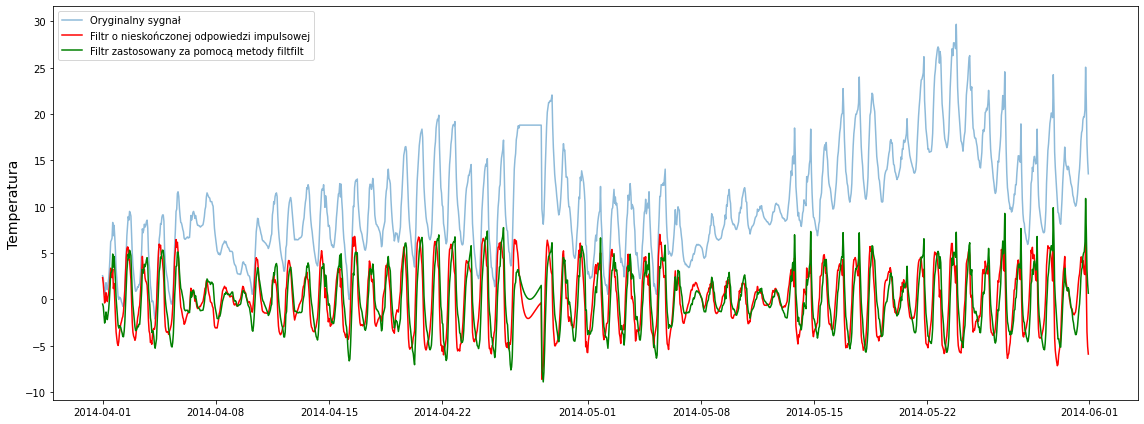

In [89]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df.index, temperature, label="Oryginalny sygnał", alpha=0.5)
ax.plot(df.index, temperature_filtered_iir, color="red", label="Filtr o nieskończonej odpowiedzi impulsowej")
ax.plot(df.index, temperature_filtered_filtfilt, color="green", label="Filtr zastosowany za pomocą metody filtfilt")
ax.set_ylabel("Temperatura", fontsize=14)
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch17-temperature-signal-iir.pdf")

In [90]:
# f, h = signal.freqz(b, a)

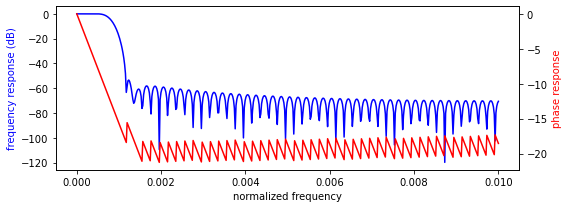

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
h_ampl = 20 * np.log10(abs(h))
h_phase = np.unwrap(np.angle(h))
ax.plot(f/max(f)/100, h_ampl, 'b')
ax.set_ylabel('frequency response (dB)', color="b")
ax.set_xlabel(r'normalized frequency')
ax = ax.twinx()
ax.plot(f/max(f)/100, h_phase, 'r')
ax.set_ylabel('phase response', color="r")
fig.tight_layout()

### Filtrowanie audio

In [92]:
b = np.zeros(5000)
b[0] = b[-1] = 1
b /= b.sum()

In [93]:
data_filt = signal.lfilter(b, 1, data)

In [94]:
io.wavfile.write("gitara-echo.wav",
                 sample_rate,
                 np.vstack([data_filt, data_filt]).T.astype(np.int16))

In [95]:
# Na podstawie: http://nbviewer.ipython.org/gist/Carreau/5507501/the%20sound%20of%20hydrogen.ipynb
from IPython.core.display import display
from IPython.core.display import HTML
def wav_player(filepath):
    src = """
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
    </audio>
    """%(filepath)
    display(HTML(src))

In [96]:
wav_player("gitara.wav")

In [97]:
wav_player("gitara-echo.wav")